In [1]:
import numpy as np
import h5py
import glob, os, re, sys

import pickle
import json
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

import astro_helper as ah
from GalDatasets import GalDataset
from train_flow import get_data, standarize_data, training_sets

from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
plt.style.use('bmh')
cmap = mpl.colormaps['viridis']  # Example: 'viridis' colormap
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

# load all the data to test

In [39]:
galaxies_to_test = ['ETG-vlowmass', 'ETG-lowmass', 'ETG-medmass', 'ETG-himass', 'NGC300', 'MW']
training_set = 'b'

In [40]:
Xs, Ys, norm_dicts = [], [], []
for galaxy_to_test in galaxies_to_test:
    galaxy_types = sorted([galaxy_to_test])
    print(galaxy_to_test)

    # define sets of training features
    # features that are reliable in cosmo sims
    input_features = training_sets(training_set)
    print(input_features)
    log_features = ['midplane-SFR-dens', 'midplane-stellar-dens', 'midplane-dens', 'weights', 'Omegazs', 'kappas',
                    'midplane-Pturb', 'midplane-Pth', 'midplane-veldispz', 'midplane-veldisp3D']
    
    X, Y = get_data(
        input_features=input_features,
        output_features=['midplane-SFR-dens'],
        galaxy_types=galaxy_types,
        log_features=log_features,
        snap_frac=0.2
    )
    X, Y, norm_dict = standarize_data(X, Y)

    X = torch.tensor(X, dtype=torch.float32)#.to(device)
    Y = torch.tensor(Y, dtype=torch.float32)#.to(device)
    print(np.shape(X), np.shape(Y))
    
    Xs.append(X)
    Ys.append(Y)
    norm_dicts.append(norm_dict)

ETG-vlowmass
['midplane-dens', 'weights']
Number of galaxy snapshots = 61
torch.Size([24667, 2]) torch.Size([24667, 1])
ETG-lowmass
['midplane-dens', 'weights']
Number of galaxy snapshots = 61
torch.Size([56368, 2]) torch.Size([56368, 1])
ETG-medmass
['midplane-dens', 'weights']
Number of galaxy snapshots = 60
torch.Size([38200, 2]) torch.Size([38200, 1])
ETG-himass
['midplane-dens', 'weights']
Number of galaxy snapshots = 60
torch.Size([85604, 2]) torch.Size([85604, 1])
NGC300
['midplane-dens', 'weights']
Number of galaxy snapshots = 61
torch.Size([23013, 2]) torch.Size([23013, 1])
MW
['midplane-dens', 'weights']
Number of galaxy snapshots = 61
torch.Size([2015, 2]) torch.Size([2015, 1])


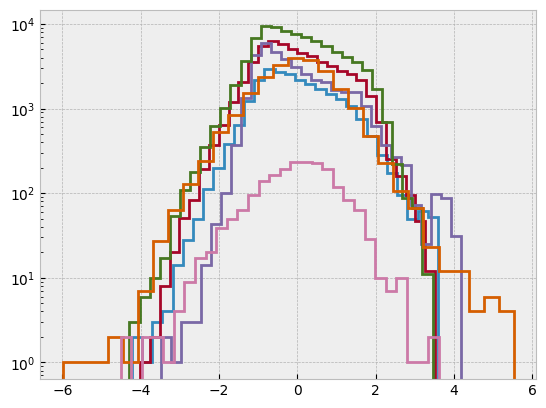

In [42]:
for X in Xs:
    plt.hist(np.array(X[:,0]), bins=30, log=True, histtype='step', lw=2)
plt.show()

# load the training data, trained on all galaxies *but* the galaxy to test

In [43]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          "NGC300",
          "Milky Way-like"]

In [48]:
X_min = -2.49
Y_min = -12.
X_max = 0.9
Y_max = 4.
X_edges = np.linspace(X_min, X_max, 30)
Y_edges = np.linspace(Y_min, Y_max, 30)
X_centers = (X_edges[1:]+X_edges[:-1])/2.
Y_centers = (Y_edges[1:]+Y_edges[:-1])/2.

/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-vlowmass/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-vlowmass/set_b/flow_e926_0.4140.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-lowmass/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-lowmass/set_b/flow_e687_0.3992.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-medmass/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-medmass/set_b/flow_e448_0.4782.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-himass/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-himass/set_b/flow_e636_0.4772.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/NGC300/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/NGC300/set_b/flow_e839_0.4543.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/MW/set_b
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/MW/set_b/flow_e695_0.2755.pkl


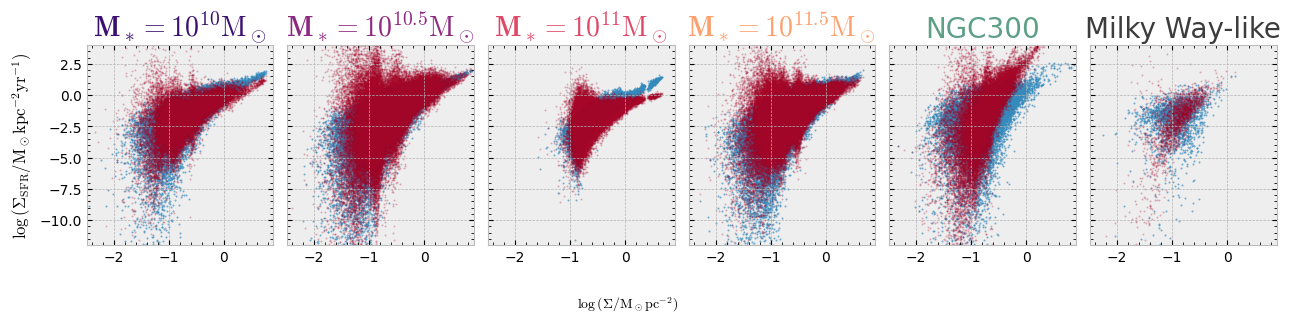

In [49]:
figW = 14
figH = 2.5
fig = plt.figure(figsize=(figW, figH))

botMarg = 0.1
topMarg = 0.1
leftMarg = 0.1
rightMarg = 0.1
wBetMarg = 0.01
hBetMarg = 0.02

crightMarg = 0.105
cW = 0.015
cBet = 0.002

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/6

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')

axs = [ax0, ax1, ax2, ax3, ax4, ax5]
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

for ax, label, i in zip(axs, labels, range(len(axs))):
    if(i<4):
        color=plt.cm.magma(float(i+1)/5.)
    elif(i==4):
        color='#5E9F87'
    else:
        color='#3C3C3C'
    ax.set_title(label, color=color, fontsize=20)

fig.text(0.45, -0.15, r'$\log{(\Sigma/{\rm M}_\odot {\rm pc}^{-2})}$')

### plot/store stuff
gen_samples_unnorm = []
for galaxy, X, Y, norm_dict, ax in zip(galaxies_to_test, Xs, Ys, norm_dicts, axs):
    path_to_data = Path(
        "/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/"
    )

    all_galaxies = ['ETG-vlowmass', 'ETG-lowmass', 'ETG-medmass', 'ETG-himass', 'NGC300', 'MW']
    path_to_data = path_to_data / galaxy
    path_to_data = path_to_data / ("set_"+training_set)
    print(path_to_data)

    # find flow pkl
    flow_paths = sorted(list(path_to_data.glob('*.pkl')))
    sorted_strings = sorted(flow_paths, key=lambda s: float(s.name.rsplit('_')[2].rsplit('.pkl')[0]))
    print(sorted_strings[0])
    if(galaxy!='ETG-medmass'):
        with open(sorted_strings[0], 'rb') as f:
            flow = pickle.load(f)
    else:
        with open(sorted_strings[10], 'rb') as f:
            flow = pickle.load(f)

    # generate the samples and check the log prob
    gen_samples = flow.sample(1, context=X).detach().cpu().numpy()

    log_prob = flow.log_prob(
        inputs=Y, 
        context=X,
    )
    log_prob.mean()

    X_unnorm = X * norm_dict['x_std'] + norm_dict['x_mean']
    Y_unnorm = Y * norm_dict['y_std'] + norm_dict['y_mean']
    
    gen_samples_unnorm_ = gen_samples * norm_dict['y_std'] + norm_dict['y_mean']

    ax.scatter(
        X_unnorm[:,0],
        Y_unnorm[:,0],
        s=1, 
        label='True',
        alpha=0.5,
    )
    ax.scatter(
        X_unnorm[:,0],
        gen_samples_unnorm_[:,0],
        s=1, 
        alpha=0.2,
        label='Generated',
    )
    gen_samples_unnorm.append(gen_samples_unnorm_)

plt.show()

# show all four on one figure (with black background and plotting specs for presentations)

In [50]:
# Plotting properties
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams['figure.facecolor'] = 'black'
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
labels_font = {'size':'20'}

cmap = plt.cm.pink
cmap.set_bad('black')

In [59]:
X_min = -2.49
Y_min = -7.9
X_max = 0.9
Y_max = 2.9
X_edges = np.linspace(X_min, X_max, 30)
Y_edges = np.linspace(Y_min, Y_max, 30)
X_centers = (X_edges[1:]+X_edges[:-1])/2.
Y_centers = (Y_edges[1:]+Y_edges[:-1])/2.

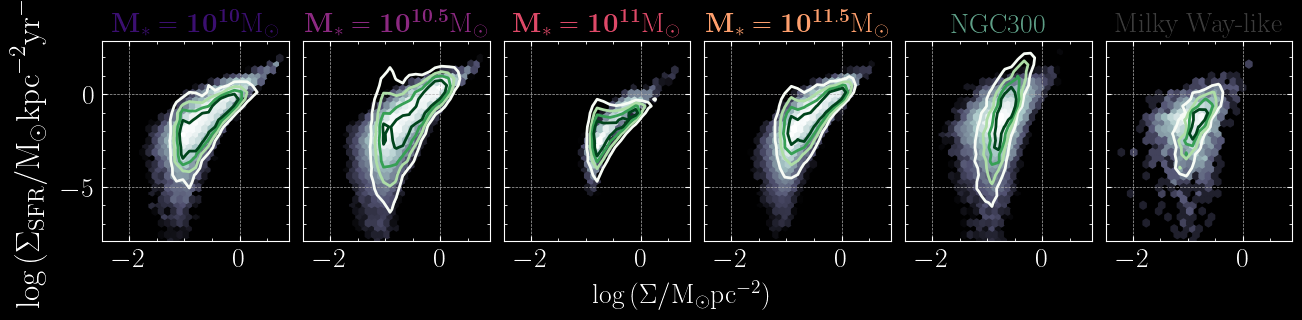

In [72]:
figW = 14
figH = 2.5
fig = plt.figure(figsize=(figW, figH))

botMarg, topMarg, leftMarg, rightMarg = 0.1, 0.1, 0.1, 0.1
wBetMarg = 0.01
hBetMarg = 0.02

crightMarg = 0.105
cW = 0.015
cBet = 0.002

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/6

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')
ax5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg, w, h],
                   ylim=[Y_min, Y_max], xlim=[X_min, X_max],
                   xlabel='', ylabel='', yticklabels='')

axs = [ax0, ax1, ax2, ax3, ax4, ax5]
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

for ax, label, i in zip(axs, labels, range(len(axs))):
    if(i<4):
        color=plt.cm.magma(float(i+1)/5.)
    elif(i==4):
        color='#5E9F87'
    else:
        color='#3C3C3C'
    ax.set_title(label, color=color, fontsize=20)

fig.text(0.45, -0.15, r'$\log{(\Sigma/{\rm M}_\odot {\rm pc}^{-2})}$')

### plot stuff
for ax, i, X, Y, norm_dict, gen_samples_unnorm_ in zip(axs, range(len(Xs)), Xs, Ys, norm_dicts, gen_samples_unnorm):
    X_unnorm = np.array(X * norm_dict['x_std'] + norm_dict['x_mean'])
    Y_unnorm = np.array(Y * norm_dict['y_std'] + norm_dict['y_mean'])
    gen_samples_unnorm_ = gen_samples_unnorm[i]

    # hexbin plot of true values
    hexagon_collection = ax.hexbin(
        X_unnorm[:,0], Y_unnorm[:,0],
        gridsize=30, extent=[X_min, X_max, Y_min, Y_max], zorder=0
    )
    hexagon_count = hexagon_collection.get_array()
    max_count = np.max(hexagon_count)
    hexagon_collection.remove() # this was just to get the max count

    ax.hexbin(X_unnorm[:,0],
        Y_unnorm[:,0],
        gridsize=30, bins='log',
        vmin = np.max(hexagon_count)/100., vmax=max_count,
        extent=[X_min, X_max, Y_min, Y_max],
        cmap=plt.cm.bone, zorder=1)

    # contours of the normalizing flow prediction
    counts, x_edge, y_edge, binnumber = binned_statistic_2d(
        X_unnorm[:,0],
        gen_samples_unnorm_[:,0,0],
        gen_samples_unnorm_[:,0,0],
        bins=(X_edges, Y_edges),
        statistic='count', expand_binnumbers='True'
    )
    maxcounts = np.max(counts)
    axs[i].contour(
        X_centers, Y_centers,
        np.transpose(counts), levels=[maxcounts/6., 2*maxcounts/6., 3*maxcounts/6., 4*maxcounts/6.],
        cmap=plt.cm.Greens, zorder=2
    )

plt.show()